<h1> Understand Batch Size Dimensions </h1>

In [34]:
from utils import TrajectoryDataset
from torch.utils.data import DataLoader
from pathlib import Path
# See Train Dimensions
PATH = Path('.')
window= 10
batch_size = 5


trainset = TrajectoryDataset(PATH / 'data/train.h5', window=window, flatten=True)
validset = TrajectoryDataset(PATH / 'data/valid.h5', window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

for i, (batch, _) in  enumerate(trainloader):
    print(f"{i} : {batch.shape}")

0 : torch.Size([5, 40, 128, 128])
1 : torch.Size([5, 40, 128, 128])
2 : torch.Size([5, 40, 128, 128])
3 : torch.Size([5, 40, 128, 128])
4 : torch.Size([4, 40, 128, 128])


<h1> Understand UNET dimensions </h1>

In [31]:

import torch
import torch.nn as nn
from nn import UNet

in_channels = 4
out_channels = 4
mod_features = 66
hidden_channels = [32, 64, 128]
hidden_blocks = [2, 3, 5]
spatial = 2

# UNET Forward : x (B, C, H, W)
unet = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    mod_features=mod_features,
    hidden_channels=hidden_channels,
    hidden_blocks=hidden_blocks,
    spatial=spatial,
)

)
batch_size = 4
x = torch.randn(batch_size, in_channels, 128, 128)


y = torch.randn(batch_size, mod_features)


output = unet(x, y)


print(output.shape)

torch.Size([4, 4, 128, 128])


<h1> Understand ScoreUNET dimensions </h1>

In [35]:
import torch
import torch.nn as nn
from score import ScoreUNet
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }


score_unet = ScoreUNet(**CONFIG)




x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten
t = torch.rand(x.shape[0], dtype=x.dtype, device=x.device)

print(f"x:  {x.shape} , t: {t.shape}")
c = None

# Forward pass through the ScoreUNet
output = score_unet(x, t, c)

# Print the output shape
print(f"Output Shape : {output.shape}")  # Should be (batch_size, channels, x, y)

x:  torch.Size([5, 40, 128, 128]) , t: torch.Size([5])
Output Shape : torch.Size([5, 40, 128, 128])


<h1> Understand VPSDE dimensions </h1>

In [47]:
import torch
import torch.nn as nn
from score import ScoreUNet, VPSDE

batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64,\
}


score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))



x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten

vpsde.loss(x)

tensor(1.2910, grad_fn=<MeanBackward0>)

<h1> Batch Loop (Ensure Architecture design is well shaped)</h1>

In [57]:
import torch
import h5py
import torch.nn as nn
from score import ScoreUNet, VPSDE

# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

'''
 Batch loop
'''
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)
for i, (batch, _) in enumerate(trainloader):
        loss = vpsde.loss(batch, w=mask)
        print(f"{i} batch : {batch.shape}, loss : {loss}")

0 batch : torch.Size([5, 40, 128, 128]), loss : nan
1 batch : torch.Size([5, 40, 128, 128]), loss : nan
2 batch : torch.Size([5, 40, 128, 128]), loss : nan
3 batch : torch.Size([5, 40, 128, 128]), loss : nan
4 batch : torch.Size([4, 40, 128, 128]), loss : nan


<h1> CPU Training Loop </h1>

In [56]:
import os
import h5py
import math
import torch
#import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange
from pathlib import Path
from utils import TrajectoryDataset
from score import ScoreUNet, MCScoreWrapper, VPSDE
from score import VPSDE

PATH = Path('.')

with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)  # Shape

TRAIN_CONFIG = {
    "epochs": 100,
    "batch_size": 5,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "scheduler": "linear",  # Can be "cosine" or "exponential"
    "embedding": 32,
    "hidden_channels": (64,),
    "hidden_blocks": (3,),
    "activation": "SiLU",
}
device = 'cpu'

'''
Definition of Denoiser and Scheduler
'''
# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
MODEL_CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**MODEL_CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

# Load Dataset
trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

trainloader = DataLoader(trainset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=False, num_workers=1, persistent_workers=True)


optimizer = optim.AdamW(vpsde.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])

# Define Learning Rate Scheduler
if TRAIN_CONFIG["scheduler"] == "linear":
    lr_lambda = lambda t: 1 - (t / TRAIN_CONFIG["epochs"])
elif TRAIN_CONFIG["scheduler"] == "cosine":
    lr_lambda = lambda t: (1 + math.cos(math.pi * t / TRAIN_CONFIG["epochs"])) / 2
elif TRAIN_CONFIG["scheduler"] == "exponential":
    lr_lambda = lambda t: math.exp(-7 * (t / TRAIN_CONFIG["epochs"]) ** 2)
else:
    raise ValueError("Invalid scheduler type")

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in (bar := trange(TRAIN_CONFIG["epochs"], ncols=88)):
    losses_train = []
    losses_valid = []

    ## Train
    vpsde.train()
    for i, (batch, _) in enumerate(trainloader):
        batch = batch.to(device)
        optimizer.zero_grad()

        # **Apply Mask**
        mask_batch = mask.to(device).expand_as(batch)  # Expand mask to match batch size
        w = mask_batch.float()  # Convert mask to weight format

        # **Compute VPSDE Loss**
        loss = vpsde.loss(batch, w=w)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach())

    ## Validation
    vpsde.eval()
    with torch.no_grad():
        for batch, _ in validloader:
            batch = batch.to(device)
            mask_batch = mask.to(device).expand_as(batch)
            w = mask_batch.float()

            loss = vpsde.loss(batch, w=w)
            losses_valid.append(loss)
    ## Compute Loss Stats
    loss_train = torch.stack(losses_train).mean().item()
    loss_valid = torch.stack(losses_valid).mean().item()
    print(f"Train Loss : {loss_train}, Valid Loss : {loss_valid}")
    lr = optimizer.param_groups[0]['lr']

    ## Step Scheduler
    scheduler.step()

  1%|▌                                                  | 1/100 [00:05<09:50,  5.97s/it]

Train Loss : nan, Valid Loss : nan


  2%|█                                                  | 2/100 [00:11<09:12,  5.64s/it]

Train Loss : nan, Valid Loss : nan


  3%|█▌                                                 | 3/100 [00:15<08:15,  5.11s/it]

Train Loss : nan, Valid Loss : nan


  3%|█▌                                                 | 3/100 [00:19<10:27,  6.46s/it]


KeyboardInterrupt: 

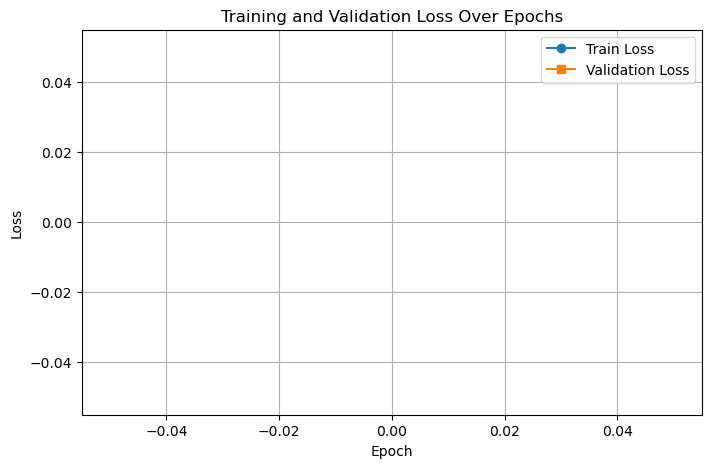

In [52]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses_train) + 1), losses_train, label="Train Loss", marker="o")
plt.plot(range(1, len(losses_valid) + 1), losses_valid, label="Validation Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
print(losses_train)

In [53]:
print(losses_train)
print(losses_valid)

[tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)]
[tensor(nan)]
